<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Data/blob/main/script/Pytorch_RNN_LSTM_AT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [5]:
# train-test split for time series
proportion = 0.70
train_size = int(len(timeseries) * proportion)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print("X_train.shape, y_train.shape = ", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape = ", X_test.shape, y_test.shape)

X_train.shape, y_train.shape =  torch.Size([96, 4, 1]) torch.Size([96, 4, 1])
X_test.shape, y_test.shape =  torch.Size([40, 4, 1]) torch.Size([40, 4, 1])


In [6]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [8]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
mseloss = nn.MSELoss()
trainloader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = mseloss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(mseloss(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(mseloss(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 229.8625, test RMSE 428.5013
Epoch 100: train RMSE 180.6750, test RMSE 376.9561
Epoch 200: train RMSE 143.1506, test RMSE 335.9407
Epoch 300: train RMSE 110.9792, test RMSE 297.5593
Epoch 400: train RMSE 84.2176, test RMSE 261.2972
Epoch 500: train RMSE 64.8290, test RMSE 229.8553
Epoch 600: train RMSE 50.1705, test RMSE 201.9977
Epoch 700: train RMSE 40.2392, test RMSE 178.2261
Epoch 800: train RMSE 33.4540, test RMSE 157.8608
Epoch 900: train RMSE 29.1101, test RMSE 140.9336
Epoch 1000: train RMSE 26.5086, test RMSE 126.9172
Epoch 1100: train RMSE 25.0323, test RMSE 115.9709
Epoch 1200: train RMSE 23.2316, test RMSE 106.8767
Epoch 1300: train RMSE 22.9818, test RMSE 100.6568
Epoch 1400: train RMSE 21.4778, test RMSE 94.7241
Epoch 1500: train RMSE 21.1481, test RMSE 89.7370
Epoch 1600: train RMSE 20.6667, test RMSE 86.3809
Epoch 1700: train RMSE 20.6176, test RMSE 85.1212
Epoch 1800: train RMSE 20.0684, test RMSE 82.9782
Epoch 1900: train RMSE 19.8876, test RMSE 80

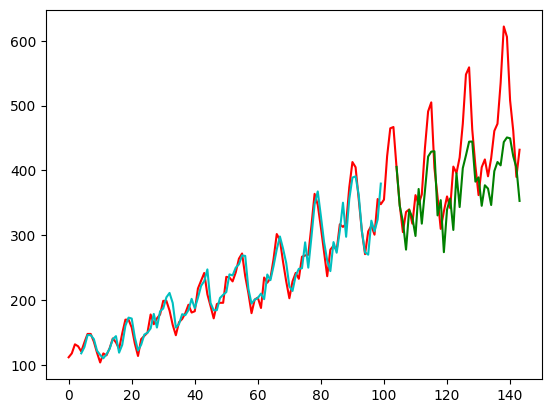

In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    # y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='r')
plt.plot(train_plot, c='c')
plt.plot(test_plot, c='g')
plt.show()